#第四次讀書會報告 - BERTopic

組別:第9組

Date:2024/05/28

# 1.載入環境及安裝套件

In [ ]:
#連接colab雲端資料夾
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#此部分可選擇檔案載入
from google.colab import files
uploaded = files.upload()

Saving dcard_set_new.csv to dcard_set_new (2).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving TaipeiSansTCBeta-Regular.ttf to TaipeiSansTCBeta-Regular (1).ttf
Saving dict.txt.big to dict.txt (1).big
Saving stopwords.txt to stopwords (1).txt


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
# 設定google drive 路徑
os.chdir('/content/drive/MyDrive/Colab Notebooks/2024_study_group9_4')
os.listdir() # 確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['bert_results_df.csv',
 'dcard_set.csv',
 'bert_results_df3.csv',
 'bert_results_df4.csv',
 'bertopic_src',
 'bertopic_tmp',
 'dcard_set_new.csv',
 'bert_results_df1.csv',
 'bert_results_df2.csv',
 'bert_results_df_new.csv',
 'dict.txt.big',
 'TaipeiSansTCBeta-Regular.ttf',
 'stopwords.txt',
 'stopwords (1).txt',
 'bert_results_new.csv',
 'LLM']

In [ ]:
#載入套件與環境設定
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('/content/drive/MyDrive/Colab Notebooks/2024_study_group9_4/TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

套件安裝

In [ ]:
!pip install jieba
!pip install sentence_transformers
!pip install ckip_transformers
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

載入套件

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# 2.資料前處理

## 2.1資料蒐集
本小組自Tarflow下載Dacrd上4個個版的文章資料集，並執行程式合成一個資料集，共3,598筆資料。

其內容包含system_id、ataSource、artUrl、artDate、artTitle、artContent、boardID(文章所屬個版)、
commentCount(評論次數)、department、gender、school等欄位。

Data includes:
*   Dcard文章 from 2024/03/01 - 2024/03/25
*   專版包含以下4板：
*   穿搭版
*   星座版
*   理財版
*   研究所版

資料來源:https://tarflow.mis.nsysu.edu.tw/login?next=%2Fmain%2F662d88ed73

## 2.2資料匯入與清理

In [ ]:
# 讀入Dcard資料集
dcard_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2024_study_group9_4/dcard_set_new.csv')
dcard_df

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/dressup/p/255078442,2024-03-25 16:18:42,#分享 150の近期日常裙裝穿搭🌸🧸 #穿出我的日系風格,https://megapx.dcard.tw/v1/images/e6ee0893-3a7...,dressup,40,ruuuuu___,F,まる🐻
1,2,Dcard,https://www.dcard.tw/f/dressup/p/255078768,2024-03-25 16:54:35,穿出我的日系風格,\麵包超人/\n因為本身長相無優勢\n所以決定用麵包超人的型態出場🤩✨\n窮超人本人真的好想...,dressup,21,clumnar,F,阿胖麵人
2,3,Dcard,https://www.dcard.tw/f/dressup/p/255078701,2024-03-25 16:45:46,#詢問 科技業女生穿搭,原本在新創公司上班，平常上班穿搭沒在管\n穿短褲、露肚臍、戴帽子 都可以\n\n但下週轉職換...,dressup,352,NaN,F,國立政治大學
3,4,Dcard,https://www.dcard.tw/f/dressup/p/255079599,2024-03-25 21:31:16,找不到李多慧的瑜伽褲品牌,NaN,dressup,3,softcindy,F,豆腐心老貓奴
4,5,Dcard,https://www.dcard.tw/f/dressup/p/255065394,2024-03-24 10:59:45,#分享 172的黑色衣櫃🐈‍⬛✨,https://megapx.dcard.tw/v1/images/61f1cb51-fb7...,dressup,24,bea.16,F,172
...,...,...,...,...,...,...,...,...,...,...,...
3589,948,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 13:17:05,收王達昌經濟學研究所講義,想要自讀 有講義、小考考卷的話最好\n非常感謝,graduate_school,5,NaN,M,國立臺北大學
3590,949,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 22:40:19,研究所上課方式,請教一下各位\n大家唸研究所的上課方式？\n我是第一堂課教授會講一下課程大綱、報告內容、分組...,graduate_school,11,mentalillness,F,吓聊
3591,950,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 14:23:21,中興應用經濟所在職專班面試,各位好！\n本人有幸通過中興應經在職專班的第一階段審查\n想請問各位面試方面除了自我介紹外教...,graduate_school,0,volleyball123,M,白底虎斑
3592,951,Dcard,https://www.dcard.tw/f/graduate_school/p/25484...,2024-03-02 06:05:29,高雄大學 亞太工商學系 教授請益,今年考試本人正取，想請益有關高大亞太系的教授\n\n目前有興趣的教授有：\n1.許博翔 教授...,graduate_school,1,NaN,M,國立聯合大學


In [ ]:
#資料集中可能有等於0或是NaN的值，故用索引選擇不等於0且不是NaN的值，接著使用dropna()方法刪除NaN的行
dcard_df = dcard_df[(dcard_df !=0) & (dcard_df.notna())].dropna()
dcard_df

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/dressup/p/255078442,2024-03-25 16:18:42,#分享 150の近期日常裙裝穿搭🌸🧸 #穿出我的日系風格,https://megapx.dcard.tw/v1/images/e6ee0893-3a7...,dressup,40.0,ruuuuu___,F,まる🐻
1,2,Dcard,https://www.dcard.tw/f/dressup/p/255078768,2024-03-25 16:54:35,穿出我的日系風格,\麵包超人/\n因為本身長相無優勢\n所以決定用麵包超人的型態出場🤩✨\n窮超人本人真的好想...,dressup,21.0,clumnar,F,阿胖麵人
4,5,Dcard,https://www.dcard.tw/f/dressup/p/255065394,2024-03-24 10:59:45,#分享 172的黑色衣櫃🐈‍⬛✨,https://megapx.dcard.tw/v1/images/61f1cb51-fb7...,dressup,24.0,bea.16,F,172
6,7,Dcard,https://www.dcard.tw/f/dressup/p/255047494,2024-03-22 10:00:10,#分享 小隻女孩𝟭𝟱𝟬𝗰𝗺 🍯近期最愛的𝟯件日牌洋裝分享(´ᵒ̴̶̷̤∀ᵒ̴̶̷̤)💛,https://megapx.dcard.tw/v1/images/dbbc7b1a-dec...,dressup,75.0,ningggg131,F,ニン·Ning
7,8,Dcard,https://www.dcard.tw/f/dressup/p/255065466,2024-03-24 11:08:57,#分享 161挑戰可甜可鹽4種穿搭🎀,哈囉大家好我是草莓奶昔🍓\n平常都在美妝版出沒的我\n今天要來分享4套可甜可鹹的穿搭🙈\n有...,dressup,5.0,susu.310,F,草莓奶昔🍓
...,...,...,...,...,...,...,...,...,...,...,...
3584,943,Dcard,https://www.dcard.tw/f/graduate_school/p/25483...,2024-03-01 12:00:12,非本科系準備機械碩士在職班,大家好\n\n請問非本科系想讀機械碩士在職班\n\n工作是機構工程師有機會進機械所嗎 ?\n...,graduate_school,5.0,工業設計學系,M,國立臺北科技大學
3586,945,Dcard,https://www.dcard.tw/f/graduate_school/p/25485...,2024-03-03 11:16:03,是否繼續讀社工研究所,不知道發這版對不對\n但是還是想問問就讀過研究所的各位\n是否該繼續就讀社工的研究所？\n\...,graduate_school,6.0,c92929,F,Lulu
3587,946,Dcard,https://www.dcard.tw/f/graduate_school/p/25483...,2024-03-01 11:01:16,大碩vs高點 管理學,目前在考慮報企研所 試聽過兩家\n管理學大碩趙老師的那堂試聽完全沒板書（線上試聽只有那堂）所...,graduate_school,18.0,laurenceee,F,🫶🏻
3588,947,Dcard,https://www.dcard.tw/f/graduate_school/p/25485...,2024-03-03 13:10:51,［分享］113台大應數所推甄,推甄分三步驟，就依順序來說：\n\n一、上傳資料：\n簡單來說就是把一些大學的豐功偉業上傳，...,graduate_school,2.0,cb26_2219,M,匿名


In [ ]:
# 移除網址格式
# 只留下中文字
dcard_df["artContent"] = dcard_df["artContent"].str.replace("(http|https)://.*", "", regex=True)
dcard_df["artTitle"] = dcard_df["artTitle"].str.replace("(http|https)://.*", "", regex=True)
dcard_df["artContent"] = dcard_df["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard_df["artTitle"] = dcard_df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard_df['content'] = dcard_df['artContent']
dcard_df['artCatagory'] = dcard_df['boardID']

# dcard_df = dcard_df.loc[:,["content", "artUrl", "artCatagory", 'artDate']] #留下文章內容、文章連結與文章種類
dcard_df.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school,content,artCatagory
0,1,Dcard,https://www.dcard.tw/f/dressup/p/255078442,2024-03-25 16:18:42,分享近期日常裙裝穿搭穿出我的日系風格,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,dressup,40.0,ruuuuu___,F,まる🐻,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,dressup
1,2,Dcard,https://www.dcard.tw/f/dressup/p/255078768,2024-03-25 16:54:35,穿出我的日系風格,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,dressup,21.0,clumnar,F,阿胖麵人,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,dressup
4,5,Dcard,https://www.dcard.tw/f/dressup/p/255065394,2024-03-24 10:59:45,分享的黑色衣櫃,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,dressup,24.0,bea.16,F,172,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,dressup


In [ ]:
#將artCatagory從英文轉中文
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('dressup','穿搭')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('horoscopes','星座')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('money','理財')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('graduate_school','研究所')

In [ ]:
# 資料前處理(4版)
# 去除一些不需要的欄位
metaData2 = dcard_df.drop(['dataSource', 'boardID', 'commentCount', 'department', 'gender', 'school'], axis=1)

# 只留下中文字
metaData2['sentence'] = metaData2['artContent'].str.replace(r'\n\n','。', regex=True)
metaData2['sentence'] = metaData2['sentence'].str.replace(r'\n','', regex=True)

metaData2['sentence'] = metaData2['sentence'].str.split("[,，。|！!？?]{1,}")
metaData2 = metaData2.explode('sentence').reset_index(drop=True)

#sentence型態轉換成str，避免資料清理出現error
metaData2['sentence'] = (metaData2['sentence'].astype(str))
metaData2['sentence'] = metaData2['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
metaData2

,system_id,artUrl,artDate,artTitle,artContent,content,artCatagory,sentence
0,1,https://www.dcard.tw/f/dressup/p/255078442,2024-03-25 16:18:42,分享近期日常裙裝穿搭穿出我的日系風格,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,穿搭,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...
1,2,https://www.dcard.tw/f/dressup/p/255078768,2024-03-25 16:54:35,穿出我的日系風格,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,穿搭,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...
2,5,https://www.dcard.tw/f/dressup/p/255065394,2024-03-24 10:59:45,分享的黑色衣櫃,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,穿搭,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...
3,7,https://www.dcard.tw/f/dressup/p/255047494,2024-03-22 10:00:10,分享小隻女孩近期最愛的件日牌洋裝分享,嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然小隻女孩買日牌就是不會錯長度都會很剛...,嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然小隻女孩買日牌就是不會錯長度都會很剛...,穿搭,嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然小隻女孩買日牌就是不會錯長度都會很剛...
4,8,https://www.dcard.tw/f/dressup/p/255065466,2024-03-24 11:08:57,分享挑戰可甜可鹽種穿搭,哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿搭有興趣的就一起看下去...,哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿搭有興趣的就一起看下去...,穿搭,哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿搭有興趣的就一起看下去...
...,...,...,...,...,...,...,...,...
1243,943,https://www.dcard.tw/f/graduate_school/p/25483...,2024-03-01 12:00:12,非本科系準備機械碩士在職班,大家好請問非本科系想讀機械碩士在職班工作是機構工程師有機會進機械所嗎目標想進中央機械臺科機械...,大家好請問非本科系想讀機械碩士在職班工作是機構工程師有機會進機械所嗎目標想進中央機械臺科機械...,研究所,大家好請問非本科系想讀機械碩士在職班工作是機構工程師有機會進機械所嗎目標想進中央機械臺科機械...
1244,945,https://www.dcard.tw/f/graduate_school/p/25485...,2024-03-03 11:16:03,是否繼續讀社工研究所,不知道發這版對不對但是還是想問問就讀過研究所的各位是否該繼續就讀社工的研究所本人就讀於大家口...,不知道發這版對不對但是還是想問問就讀過研究所的各位是否該繼續就讀社工的研究所本人就讀於大家口...,研究所,不知道發這版對不對但是還是想問問就讀過研究所的各位是否該繼續就讀社工的研究所本人就讀於大家口...
1245,946,https://www.dcard.tw/f/graduate_school/p/25483...,2024-03-01 11:01:16,大碩高點管理學,目前在考慮報企研所試聽過兩家管理學大碩趙老師的那堂試聽完全沒板書線上試聽只有那堂所以不知道怎...,目前在考慮報企研所試聽過兩家管理學大碩趙老師的那堂試聽完全沒板書線上試聽只有那堂所以不知道怎...,研究所,目前在考慮報企研所試聽過兩家管理學大碩趙老師的那堂試聽完全沒板書線上試聽只有那堂所以不知道怎...
1246,947,https://www.dcard.tw/f/graduate_school/p/25485...,2024-03-03 13:10:51,分享台大應數所推甄,推甄分三步驟就依順序來說一上傳資料簡單來說就是把一些大學的豐功偉業上傳有按照規定在期限內上傳...,推甄分三步驟就依順序來說一上傳資料簡單來說就是把一些大學的豐功偉業上傳有按照規定在期限內上傳...,研究所,推甄分三步驟就依順序來說一上傳資料簡單來說就是把一些大學的豐功偉業上傳有按照規定在期限內上傳...


In [ ]:
#將dataframe儲存為csv檔
metaData2.to_csv("/content/drive/MyDrive/Colab Notebooks/2024_study_group9_4/metaData2_news.csv", encoding = 'utf-8',index = True)

# 3.Token classification
#### 3.1 NER
使用 Huggingface 上面已經針對 NER 任務 finetune 好的 BERT 模型來實作<br>
Huggingface 的模型列表：https://huggingface.co/models?sort=trending

中文 NER：

使用套件：transformers

使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

使用 CKIP 開發的 NLP 套件：ckip_transformers

使用的 WS 模型：https://huggingface.co/ckiplab/bert-base-chinese-ws

使用的 POS 模型：https://huggingface.co/ckiplab/bert-base-chinese-pos

使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
# 初始化 ckip 工具
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0)
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0)
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0)

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
text = metaData2['sentence'].tolist()

# 執行
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results


Inference: 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]


,sentence,packed_sentence,entities
0,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,大家(Nh) 好(VH) 我(Nh) 是(SHI) 身高(Na) 體重(Na) 很(Dfa)...,"[NerToken(word='兩', ner='CARDINAL', idx=(280, ..."
1,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,麵包(Na) 超人(Na) 因為(Cbb) 本身(Nh) 長相(Na) 無(VJ) 優勢(N...,"[NerToken(word='第一', ner='ORDINAL', idx=(41, 4..."
2,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,哈囉(Nb) 大家(Nh) 好(Dfa) 久(VH) 不見(D) 竟然(D) 隔(VJ) 了...,"[NerToken(word='兩年', ner='DATE', idx=(12, 14))..."
3,嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然小隻女孩買日牌就是不會錯長度都會很剛...,嗨(I) 嗨(I) 我(Nh) 是(SHI) 寧(VK) 這(Nep) 次(Nf) 想(VE...,"[NerToken(word='第一', ner='ORDINAL', idx=(89, 9..."
4,哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿搭有興趣的就一起看下去...,哈囉(I) 大家(Nh) 好(VH) 我(Nh) 是(SHI) 草莓(Na) 奶昔(Na) ...,"[NerToken(word='今天', ner='DATE', idx=(22, 24))..."
...,...,...,...
1243,大家好請問非本科系想讀機械碩士在職班工作是機構工程師有機會進機械所嗎目標想進中央機械臺科機械...,大家(Nh) 好(VH) 請問(VE) 非(A) 本(Nes) 科系(Na) 想(VE) 讀...,"[NerToken(word='中央機械臺科機械北科機電所', ner='ORG', idx..."
1244,不知道發這版對不對但是還是想問問就讀過研究所的各位是否該繼續就讀社工的研究所本人就讀於大家口...,不(D) 知道(VK) 發(VD) 這(Nep) 版(Na) 對(VH) 不(D) 對(VH...,"[NerToken(word='三', ner='CARDINAL', idx=(50, 5..."
1245,目前在考慮報企研所試聽過兩家管理學大碩趙老師的那堂試聽完全沒板書線上試聽只有那堂所以不知道怎...,目前(Nd) 在(P) 考慮(VE) 報(VC) 企研所(Nc) 試聽(VC) 過(Di) ...,"[NerToken(word='兩', ner='CARDINAL', idx=(12, 1..."
1246,推甄分三步驟就依順序來說一上傳資料簡單來說就是把一些大學的豐功偉業上傳有按照規定在期限內上傳...,推甄(Na) 分(VC) 三(Neu) 步驟(Na) 就(D) 依(P) 順序(Na) 來(...,"[NerToken(word='三', ner='CARDINAL', idx=(3, 4)..."


透過以上程式碼可得知文章中句子NER的結果

#4.Sequence classification

使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment

情緒：

1: Semi-negation

2: Negation

3: Neutral

4: Semi-positive

5: Positive

In [ ]:
# 獲取模型的最大輸入長度max_length。因bert模型最大長度為512字元
# 在創建sentiment_pipeline時,添加了truncation=True和max_length=max_length兩個參數,
# 以確保超長輸入會被自動截斷到允許的最大長度。
# 對於長度超過512的輸入句子,會被自動截斷到512個token,從而避免了RuntimeError的發生。

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 載入tokenizer和模型
model_name = "techthiyanes/chinese_sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
max_length = model.config.max_position_embeddings  # 獲取模型的最大輸入長度

# 建立情感分析pipeline
sentiment_pipeline = pipeline('text-classification', model=model, tokenizer=tokenizer, truncation=True, max_length=max_length)

# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = metaData2['sentence']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    # 進行情緒分析
    outputs = sentiment_pipeline(sentence)[0]
    # 從模型輸出中提取label和score
    label = outputs['label']
    score = outputs['score']
    return pd.Series([label, score])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = results_df['sentence'].apply(analyze_sentiment)

# 輸出結果
#print(results_df)
results_df


,sentence,label,score
0,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,star 5,0.623883
1,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,star 5,0.393314
2,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,star 5,0.696505
3,嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然小隻女孩買日牌就是不會錯長度都會很剛...,star 5,0.856467
4,哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿搭有興趣的就一起看下去...,star 5,0.510813
...,...,...,...
1243,大家好請問非本科系想讀機械碩士在職班工作是機構工程師有機會進機械所嗎目標想進中央機械臺科機械...,star 5,0.457154
1244,不知道發這版對不對但是還是想問問就讀過研究所的各位是否該繼續就讀社工的研究所本人就讀於大家口...,star 4,0.375950
1245,目前在考慮報企研所試聽過兩家管理學大碩趙老師的那堂試聽完全沒板書線上試聽只有那堂所以不知道怎...,star 4,0.594998
1246,推甄分三步驟就依順序來說一上傳資料簡單來說就是把一些大學的豐功偉業上傳有按照規定在期限內上傳...,star 4,0.342530


透過以上程式,可使用bert情緒分析模型,分析出每個句子的label與情感分數,例如索引值3"我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然小隻女孩買日牌.....",此句子為label5,表示為Positive,情感分數為0.856467

In [ ]:
#儲存Bert模型情緒結果
results_df.to_csv("/content/drive/MyDrive/Colab Notebooks/2024_study_group9_4/bert_results_new.csv", encoding = 'utf-8',index = True)

#5.Text Clustering - BERTopic
以下使用 BERTopic 來實作 BERT-based 的 Text Clustering，並介紹 clustering-based 的主題模型

BERTopic: https://maartengr.github.io/BERTopic/index.html

以下部分先讀取資料集中文章句子,設定資料停用詞，並設定embedding model,

將中文文章轉換為embedding後再定義不同clustering所要使用的模型與方法

利用 jieba斷詞的建立一個CountVectorizer取出向量,

最後再使用 BERTopic 進行主題模型建立

In [ ]:
# 取出資料集中句子800筆資料並轉成list格式
docs_zh = metaData2['sentence'].tolist()[:800]

# 設定繁體中文詞庫
#jieba.set_dictionary('./dict/dict.txt.big')
jieba.set_dictionary('/content/dict.txt.big')

# 新增 stopwords
with open('/content/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    filtered_words = [word for word in words if len(word) >= 2]
    return filtered_words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\b\w+\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2024-05-18 16:30:28,202 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-18 16:30:31,677 - BERTopic - Dimensionality - Completed ✓
2024-05-18 16:30:31,679 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-18 16:30:31,705 - BERTopic - Cluster - Completed ✓
2024-05-18 16:30:31,709 - BERTopic - Representation - Extracting topics from clusters using representation models.
Building prefix dict from /content/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/dict.txt.big ...
Loading model from cache /tmp/jieba.u501edca284da514cb68b53a20324f4e3.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u501edca284da514cb68b53a20324f4e3.cache
Loading model cost 1.152 seconds.
DEBUG:jieba:Loading model cost 1.152 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
2024-05-18 16:30:33,919 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,391,0_搭配_喜歡_上衣_分享,"[搭配, 喜歡, 上衣, 分享, 外套, 真的, 這件, 鞋子, 衣服, 洋裝, 背心, 褲...",[哈囉大家好久不見雖然北部的天氣陰晴不定不過也是變溫暖了許多今天來分享近期的穿搭希望你們會喜...
1,1,171,1_教授_面試_備取_學長,"[教授, 面試, 備取, 學長, 請問, 老師, 小弟, 題目, 謝謝, 相關, 考試, 實...",[小弟我今年有幸考上交大資甲研究所正在選擇教授目前對於黃世強教授研究的領域有興趣也與老師約好...
2,2,142,2_投資_利率_股票_資金,"[投資, 利率, 股票, 資金, 貸款, 利息, 比特, 信貸, 美債, 銀行, 金額, 報...",[身為一個小資族有了一筆積蓄之後打算開始學習投資但台股的有近檔而且每一檔的選股邏輯和特性都不...
3,3,77,3_朋友_星座_感情_主動,"[朋友, 星座, 感情, 主動, 事情, 喜歡, 工作, 水瓶, 處女, 真愛, 女生, 訊...",[需要思考的愛還算是愛嗎嘴硬真的會讓你錯過很多事情面對愛情你夠勇敢嗎今天我們就從星座的太陽金...
4,4,19,4_答案_備穩_準時_師大,"[答案, 備穩, 準時, 師大, 放榜, 連結, , , , , , , , , , , ,...","[由左至右答案, 由左至右答案, 由左至右答案]"


透過BERTopic將本小組資料集分出5個主題,其中4個主題與本資料集相符,另一個主題則是與研所主題相同,只是被多分出一個,準確度算相當高。例如Topic0是穿搭主題,其代表字出現“搭配, 喜歡, 上衣, 分享, 外套, 真的, 這件, 鞋子, 衣服, 洋裝, 背心, 褲子等等”,很明顯看出其與穿搭相符。

In [ ]:
#視覺化呈現Topic Distance Map
zh_topic_model.visualize_topics()

In [ ]:
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


In [ ]:
zh_topic_model.visualize_distribution(topic_distr[10])

In [ ]:
#列出所選主題的詞彙頻率,此為topic(2)理財版
zh_topic_model.get_topic(2)

[('投資', 0.062109960717438566),
 ('利率', 0.046855368826372944),
 ('股票', 0.034631792843244635),
 ('資金', 0.029737001097671783),
 ('貸款', 0.02918025279759524),
 ('利息', 0.02918025279759524),
 ('比特', 0.0286207126840339),
 ('信貸', 0.027492985868681947),
 ('美債', 0.026924655178052655),
 ('銀行', 0.026353244180717404),
 ('金額', 0.025787200146712076),
 ('報酬', 0.022855190446524554),
 ('定期', 0.0222596565863106),
 ('申請', 0.02189917173621075),
 ('淨資產', 0.02105681653313394),
 ('買入', 0.020938233911845464),
 ('現金', 0.020823549709774434),
 ('定額', 0.020449241187711128),
 ('市場', 0.020330719411301733),
 ('配息', 0.01983736693730873),
 ('公司', 0.019600661411139208),
 ('資產', 0.019221033732877344),
 ('風險', 0.01898858110287462),
 ('請問', 0.018760512477163125),
 ('台股', 0.017974287183514376),
 ('價格', 0.017815474350227074),
 ('申購', 0.017343485971438036),
 ('帳戶', 0.01711206366852077),
 ('中信', 0.016707446316397055),
 ('科技', 0.016427168133439522)]

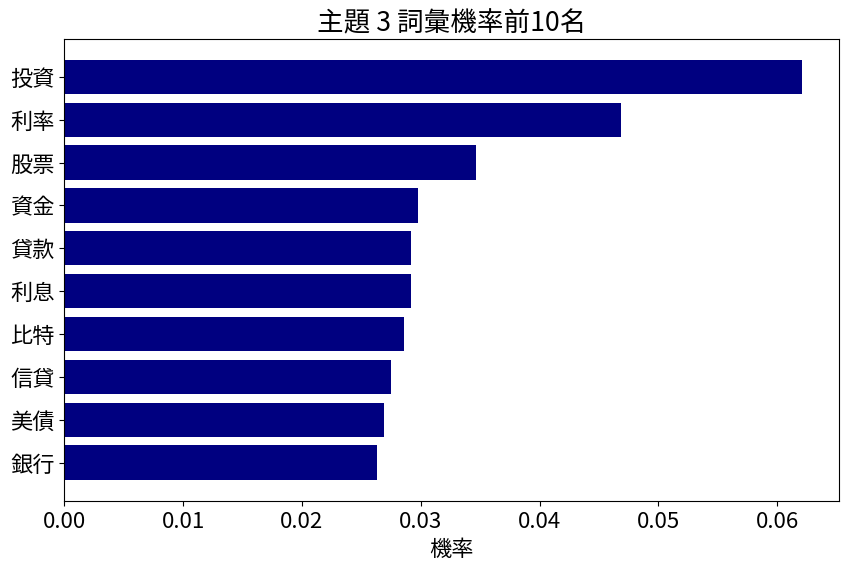

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n+1} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

以上結果得知,在資料集中,此時間Dacrd理財版出現頻率最高詞彙為投資，其次利率，再者股票,

此跟近期股市大漲,升息議題等因素息息相關,才會成為頻率出現最高的詞彙．

另外也因爲之前比特幣暴漲,使得研究的人增多，也成為討論的熱門議題．